# <center>Fruit and Vegetable Classification Using Deep Learning</center>

<font size=3.5>The intention of this project is to acquaint myself with the discipline of computer vision as well as machine learning, particularly deep learning. Prior to this project, I had next to experience in machine learning. It's an adaptation of Raymond Reed's project on classifying seedlings. The link to the jupyter notebook of that project can be found here:<br>https://github.com/Reedr1208/seedling_classification/blob/master/Seedling_Classification.ipynb<br>
I also consulted Horea Muresan and Mihai Oltean's paper on fruit recognition from images using deep learning (2018).<br>
</font>

<font size=3.5>The dataset for the project was obtained from Kaggle and can be found here: https://www.kaggle.com/moltean/fruits</font>


In [1]:
import pandas as pd
import numpy as np
import keras
import os
import matplotlib.pyplot as plt
from keras.preprocessing import image
import random
import pickle
from keras import models, layers, callbacks
import shutil
import cv2
from math import sqrt, floor
from prettytable import PrettyTable 

In [2]:
def print_bold(text):
    print('\033[1m{}\033[0m'.format(text))

def list_files(startpath):
    for root, dirs, files in os.walk(startpath):
        # os.sep represents the pathname separator used by one's operating system (usually / or \)
        # The below code replaces the starting path with an empty string and counts the number of 
        # separators to get the level of the file/directory.
        level = root.replace(startpath, '').count(os.path.sep)
        indent = ' ' * 4 * level
        dir_name = '{}{}/'.format(indent, os.path.basename(root))
        if dir_name.strip().startswith('.'):
            continue
        
        print_bold(dir_name)

        subindent = ' ' * 4 * (level + 1)
        if level == 0:
            for f in files:
                # skip hidden files
                if f.startswith('.'): 
                    continue
                # print files in the first level.
                print('{}{}'.format(subindent, f))
        else:
            for i, f in enumerate(files):
                if f.startswith('.'): continue
                print('{}{}'.format(subindent, f))
                if i == 2:
                    # stop printing if there are more than 3 files in the folder.
                    print('{}{}'.format(subindent, '...'))
                    break
        print()

list_files(os.path.join(os.getcwd(), 'fruits-360_dataset'))

fruits-360_dataset/

    fruits-360/
        LICENSE
        readme.md
        ...

        Test/

            Tomato 4/
                r_226_100.jpg
                121_100.jpg
                188_100.jpg
                ...

            Apple Red Delicious/
                r_150_100.jpg
                18_100.jpg
                235_100.jpg
                ...

            Tomato 3/
                257_100.jpg
                18_100.jpg
                r_3_100.jpg
                ...

            Huckleberry/
                r_236_100.jpg
                r_226_100.jpg
                257_100.jpg
                ...

            Blueberry/
                r_236_100.jpg
                247_100.jpg
                r_226_100.jpg
                ...

            Pear Red/
                247_100.jpg
                257_100.jpg
                198_100.jpg
                ...

            Banana Lady Finger/
                r_150_100.jpg
                r_140_100.jpg
                r_132_

            Grape Pink/
                r_236_100.jpg
                247_100.jpg
                r_226_100.jpg
                ...

            Banana Red/
                257_100.jpg
                r_78_100.jpg
                r_68_100.jpg
                ...

            Cucumber Ripe 2/
                r_226_100.jpg
                r_78_100.jpg
                r_140_100.jpg
                ...

            Physalis/
                r_236_100.jpg
                r_226_100.jpg
                257_100.jpg
                ...

            Cherry Rainier/
                r_236_100.jpg
                247_100.jpg
                r_226_100.jpg
                ...

            Maracuja/
                r_236_100.jpg
                247_100.jpg
                257_100.jpg
                ...

            Chestnut/
                r_78_100.jpg
                r_68_100.jpg
                r_150_100.jpg
                ...

            Plum/
                r_236_100.jpg
                247_1

            Banana/
                198_100.jpg
                188_100.jpg
                r_122_100.jpg
                ...

            Apple Red 2/
                r_236_100.jpg
                r_150_100.jpg
                r_140_100.jpg
                ...

            Onion Red/
                r2_107_100.jpg
                27_100.jpg
                128_100.jpg
                ...

            Physalis with Husk/
                247_100.jpg
                r_226_100.jpg
                153_100.jpg
                ...

            Apple Red Yellow 2/
                r_132_100.jpg
                153_100.jpg
                45_100.jpg
                ...

            Grape Blue/
                198_100.jpg
                386_100.jpg
                18_100.jpg
                ...

            Lemon Meyer/
                225_100.jpg
                235_100.jpg
                310_100.jpg
                ...

            Plum 2/
                r_236_100.jpg
                r_244_

Above, I preview the folder structure of the dataset. This particular dataset was obtained from kaggle

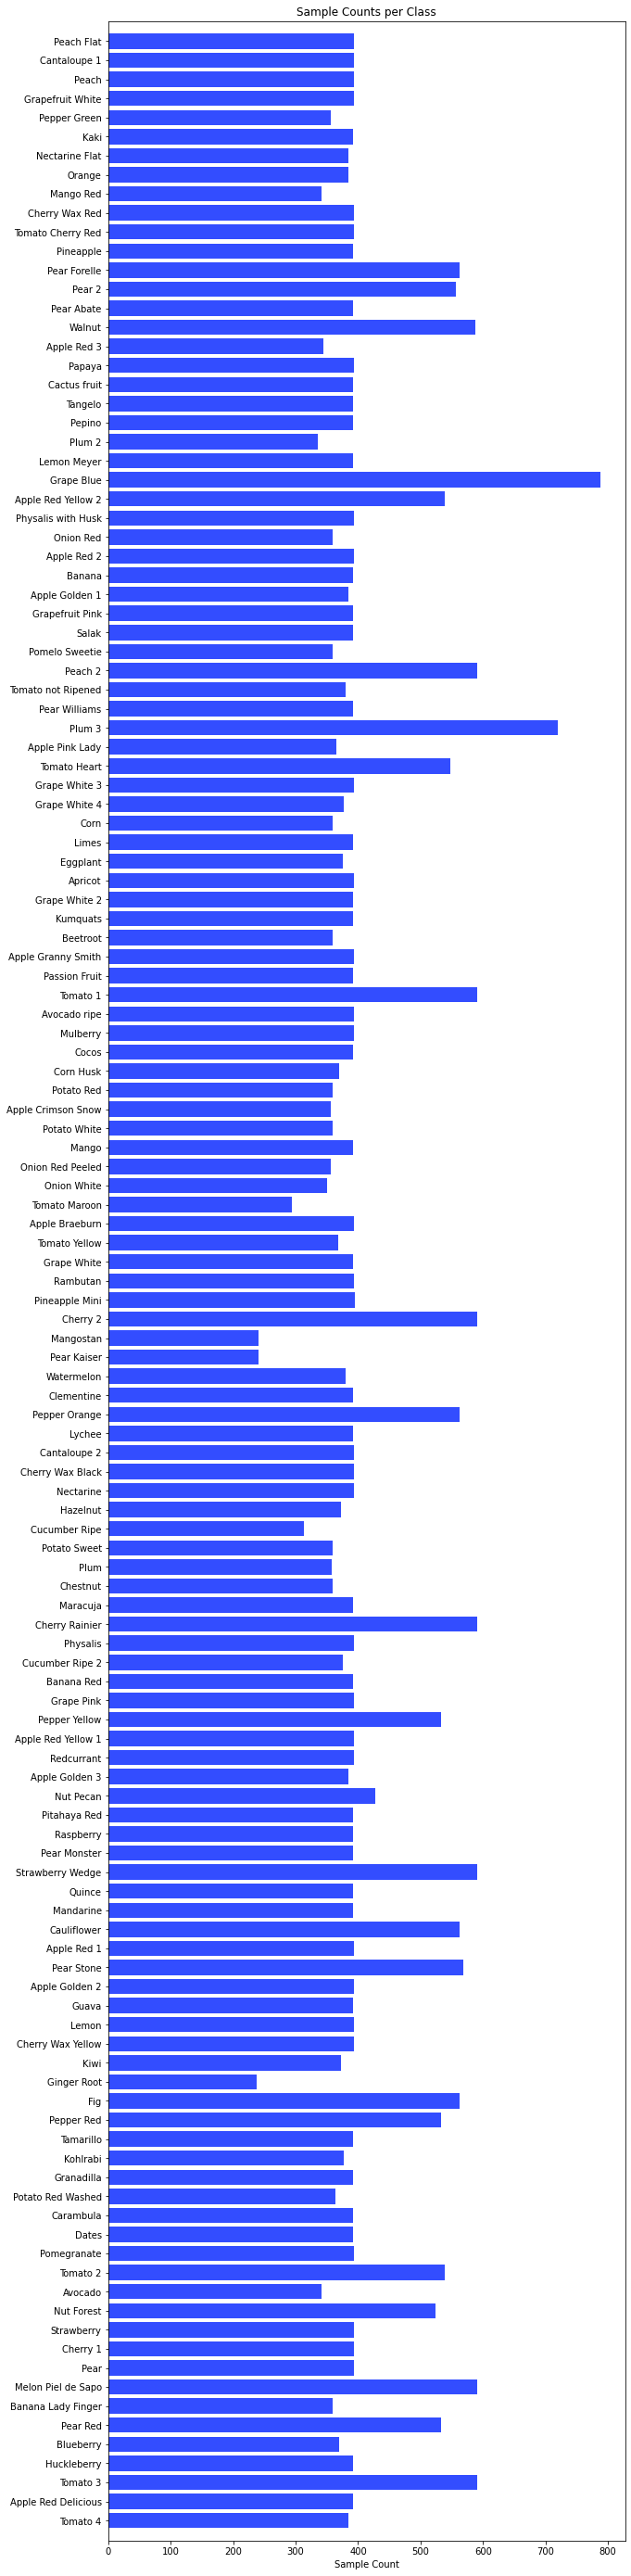

In [3]:
classes = []
sample_counts = []

startpath = 'fruits-360_dataset/fruits-360/Training'

for f in os.listdir(startpath):
    train_class_path = os.path.join(startpath, f)
    if os.path.isdir(train_class_path):
        classes.append(f)
        sample_counts.append(len(os.listdir(train_class_path)))

fig = plt.figure(figsize=(10, 50))
ax = fig.add_subplot()
plt.rcdefaults()

y_pos = np.arange(len(classes))

ax.barh(y_pos, width=sample_counts, height=0.8, align='center', color=(0.2, 0.3, 1))
ax.set_yticks(y_pos)
ax.set_yticklabels(classes)
ax.set_xlabel("Sample Count")
ax.set_title("Sample Counts per Class")
# reduce padding above and below bars. Number must be float within the range [0, 1]
ax.margins(y=0.005)

plt.show()

Most classes have a sample count of ~500, but they're not all equal. There's a risk of the model overfitting for the classes with a larger sample count. For this reason, the sample count for each class should be equalized. 

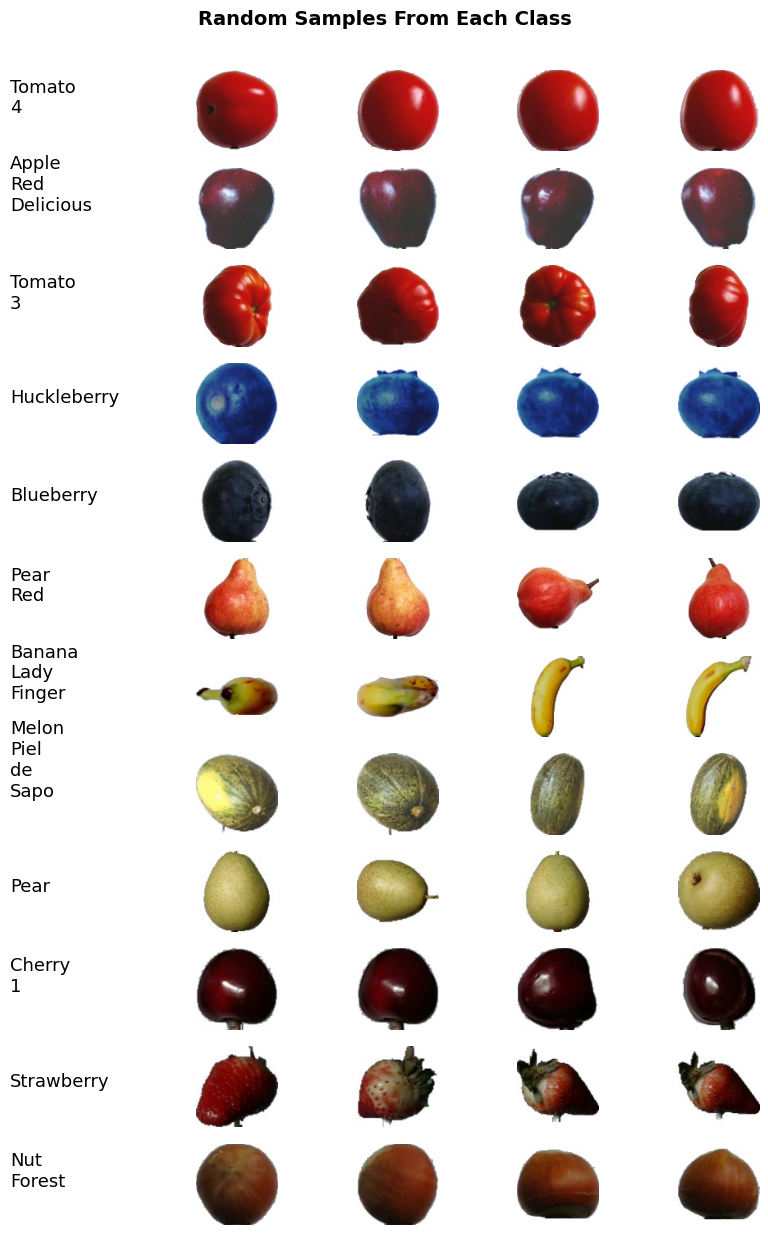

In [5]:
fig = plt.figure(figsize=(10, 15))
fig.suptitle('Random Samples From Each Class', fontsize=14, y=.92, weight='bold', horizontalalignment='center')

columns, rows = 5, 12
startpath = os.getcwd() + '/fruits-360_dataset/fruits-360/Training'
for i in range(rows):
    sample_class = os.path.join(startpath, classes[i])
    for j in range(1, columns+1):
        # last parameter indicates the index of the subplot.
        fig.add_subplot(rows, columns, i*5+j)
        plt.axis('off')
        # first column is reserved for the class name.
        if j == 1:
            plt.text(0.0, 0.5, str(classes[i].replace(' ', '\n')), fontsize=13, wrap=True)
            continue
        random_image = os.path.join(sample_class, random.choice(os.listdir(sample_class)))
        # image is from keras.preprocessing
        img = image.load_img(random_image, target_size=(100, 100))
        # img_to_array converts image into numpy array.
        img = image.img_to_array(img)
        # divide all rgb values by 255 to get a floating point value in the range [0, 1]
        img /= 255
        plt.imshow(img)
        

The one obvious commonality amongst the images within this dataset is that all of them contain an object with a white background. This, of course, makes it extremely easy to separate the object from the background. 

In addition to that, they are all square images (100x100), which means we don't have to do any image resizing.

One other thing to note is that the dataset did not come with samples for validation. For this reason, I'll separate 20% of the training dataset for validation. 

In [6]:
# creating a validation dataset
def create_validation_dataset(validation_split=0.2):
    if os.path.isdir('Validation'):
        print('Validation dataset already created.')
        print('Process terminated.')
        return
    startpath = 'fruits-360_dataset/fruits-360'
    os.mkdir(os.path.join(startpath, 'Validation'))
    for f in os.listdir(os.path.join(startpath, 'Training')):
        train_class_path = os.path.join(startpath, 'Training', f)
        if os.path.isdir(train_class_path):
            validation_class_path = os.path.join(startpath, 'Validation', f)
            os.mkdir(os.path.join(validation_class_path))
            files_to_move = int(validation_split*len(os.listdir(train_class_path)))
            for i in range(files_to_move):
                random_image = os.path.join(train_class_path, random.choice(os.listdir(train_class_path)))
                shutil.move(random_image, validation_class_path)
                
    print('Validation set created successfully using {:.2%} of the training data'.format(validation_split))


In [25]:
create_validation_dataset()

Validation set created successfully using 20.00% of the training data


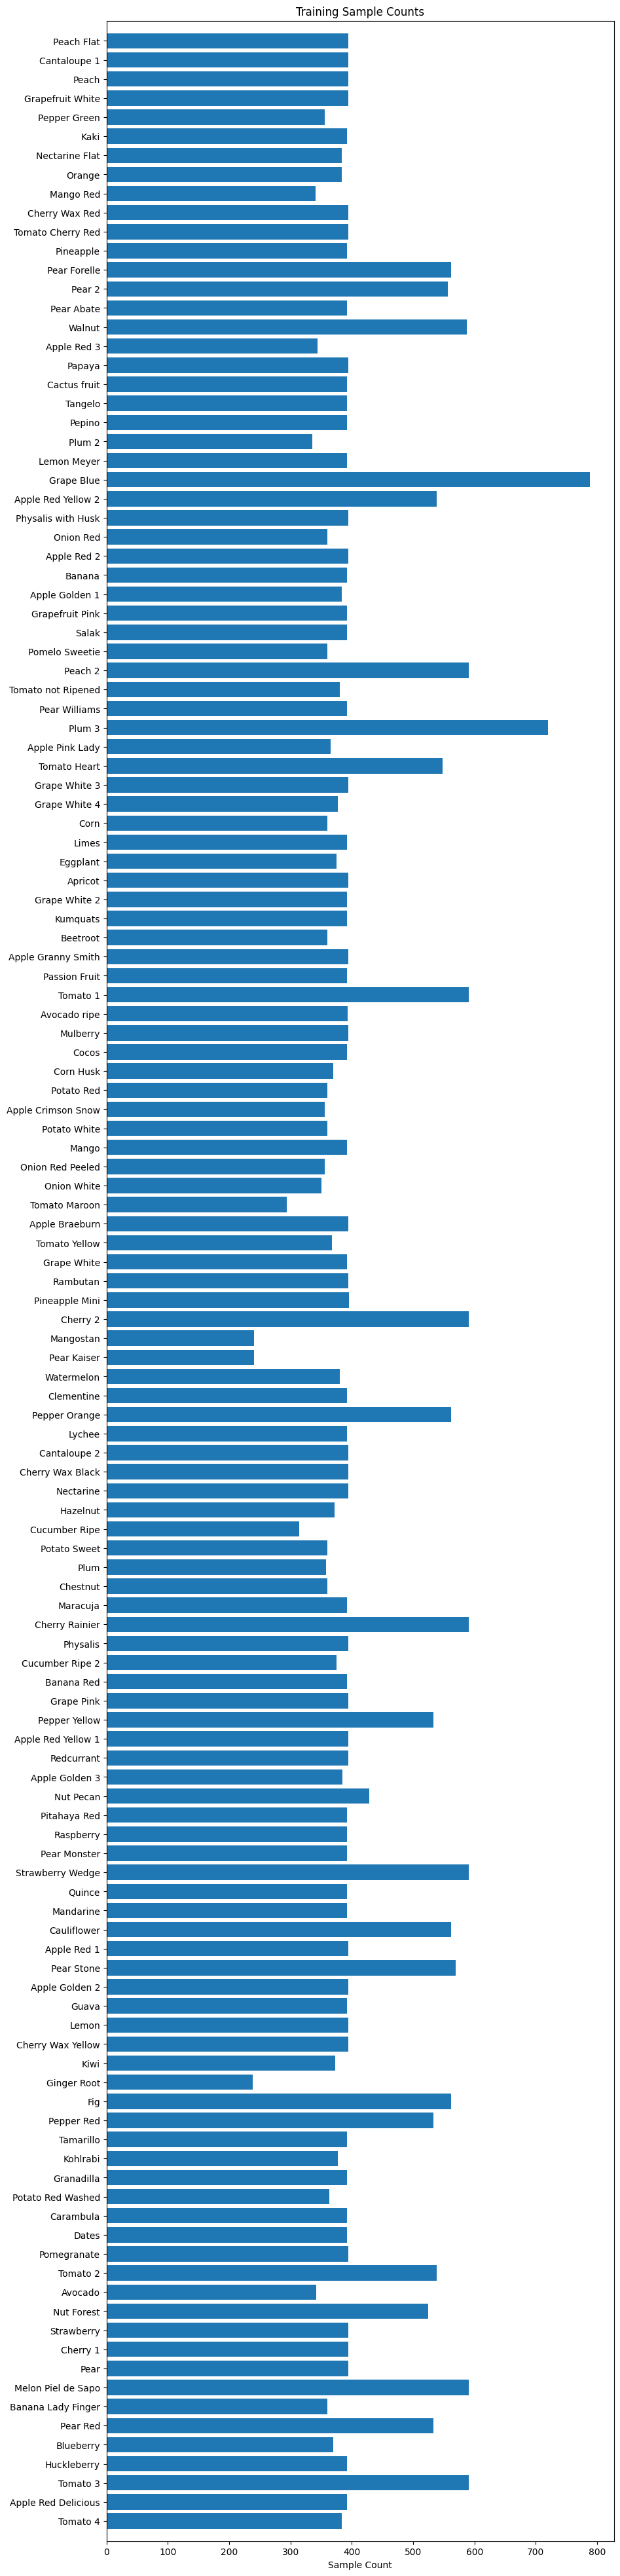

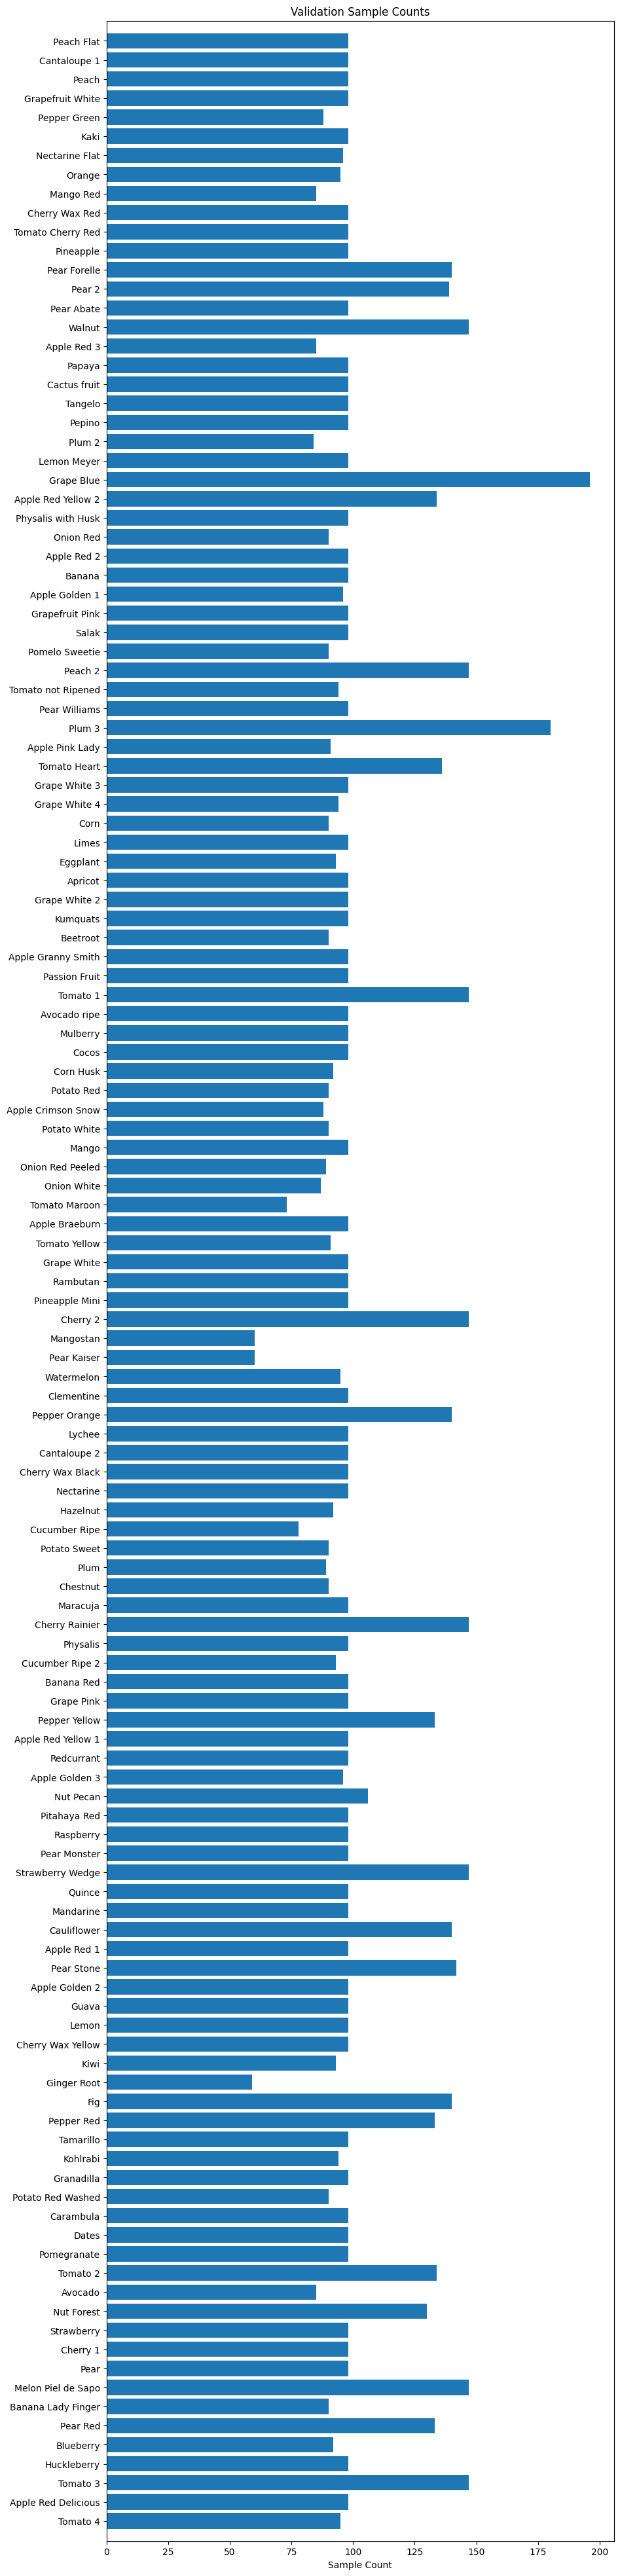

In [7]:
sample_counts = {}
startpath = 'fruits-360_dataset/fruits-360'

for i, d in enumerate(['Training', 'Validation']):
    classes = []
    sample_counts[d] = []
    
    path_to_dataset = os.path.join(startpath, d)
    for f in os.listdir(path_to_dataset):
        class_path = os.path.join(path_to_dataset, f)
        if os.path.isdir(class_path):
            classes.append(f)
            sample_counts[d].append(len(os.listdir(class_path)))
    
    fig = plt.figure(figsize=(10, 50))
    ax = fig.add_subplot()
    
    y_pos = np.arange(len(classes))
    
    ax.barh(y_pos, sample_counts[d], align='center')
    ax.set_yticks(y_pos)
    ax.set_yticklabels(classes)
    ax.set_xlabel('Sample Count')
    ax.set_title('{} Sample Counts'.format(d))
    ax.margins(y=0.005)
    
    
plt.show()

In [8]:
train_datagen = image.ImageDataGenerator(
    rescale = 1./255,
    rotation_range = 40,
    horizontal_flip = True,
    vertical_flip = True,
    fill_mode = 'nearest'
    )

test_datagen = image.ImageDataGenerator(rescale=1./255)

In [9]:
startpath = 'fruits-360_dataset/fruits-360'
training_dataset_directory = os.path.join(startpath, 'Training')
validation_dataset_directory = os.path.join(startpath, 'Validation')
test_dataset_directory = os.path.join(startpath, 'Test')

train_generator = train_datagen.flow_from_directory(
    training_dataset_directory,
    target_size=(100,100),
    batch_size=20,
    class_mode='categorical',
    )

validation_generator = test_datagen.flow_from_directory(
    validation_dataset_directory,
    target_size=(100, 100),
    batch_size = 20,
    class_mode='categorical'
    )

test_generator = test_datagen.flow_from_directory(
    test_dataset_directory,
    target_size=(100,100),
    batch_size=1,
    class_mode='categorical',
    shuffle='false',
    )


Found 54190 images belonging to 131 classes.
Found 13502 images belonging to 131 classes.
Found 22688 images belonging to 131 classes.


In [86]:
label_map = {}
# generator.class_indices is a dictionary where the key is the name of the class and the value is the index.
# The label map swaps the keys with their corresponding values. 
for k, v in train_generator.class_indices.items():
    label_map[v] = k

# pd.set_option("display.max_rows", 8)
# generator.classes returns a numpy.ndarray containing the index of the class of each image. 
# So, for example, if there are four images in the class with index 0, the ndarray will contain
# four 0s. 
# pd.Series(data) produces a one-dimensional labelled data structure.
# pd.Series.value_counts(sort: bool, ascending: bool, normalize: bool, returns relative frequencies of unique values)
# returns a pd.Series containing counts of unique values.
class_counts = pd.Series(train_generator.classes).value_counts()
class_weights = {}

# i is the index of the class, while c is the number of samples within that class.
# class_weights stores weights of the classes which is determined by the number of images in each class.
# The more images within the class, the lesser the weight for that particular class.
for i, c in class_counts.items():
    class_weights[i] = 1.0/c

norm_factor = np.mean(list(class_weights.values()))


0.002504381363217331

*testing if git detects this modification*